In [1]:
import torch
import numpy as np
import pickle
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPCOH = 100

In [3]:
x_train = np.load('./SLTCDataset/20NGPreprocessed/x_train.npy')
y_train = np.load('./SLTCDataset/20NGPreprocessed/y_train.npy')
x_test = np.load('./SLTCDataset/20NGPreprocessed/x_test.npy')
y_test = np.load('./SLTCDataset/20NGPreprocessed/y_test.npy')
with open('./SLTCDataset/20NGPreprocessed/voc.data', 'rb') as f:
    voc = pickle.load(f)

In [4]:
trainDataset  = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
testDataset = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

In [5]:
trainDataLoader = DataLoader(trainDataset, batch_size = 32)
testDataLoader = DataLoader(testDataset, batch_size = 32)

In [6]:
class WordEmb(torch.nn.Module):

    def __init__(self, voc_size, embedding_dim) -> None:
        super(WordEmb, self).__init__()
        self.embeddinglayer = torch.nn.EmbeddingBag(voc_size, embedding_dim)
        self.dropout = torch.nn.Dropout(p = 0.5)
        self.linear1 = torch.nn.Linear(embedding_dim, 64)
        self.linear2 = torch.nn.Linear(64, 20)

    def forward(self, x):
        x = torch.nn.functional.relu(self.dropout(self.embeddinglayer(x)))
        x = torch.nn.functional.relu(self.dropout(self.linear1(x)))
        return self.linear2(x)

In [7]:
for x, y in trainDataLoader:
    print(y)
    break

tensor([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4,  8, 19,  4, 14,  6,  0,  1,  7,
        12,  5,  0, 10,  6,  2,  4,  1, 12,  9, 15,  7,  6, 13])


In [8]:
model = WordEmb(len(voc), 200).to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()
opti = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []
for epoch in tqdm(range(EPCOH)):
    for x, y in trainDataLoader:
        opti.zero_grad()
        x, y= x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opti.step()
    losses.append(loss.item())


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


In [9]:
import matplotlib.pyplot as plt

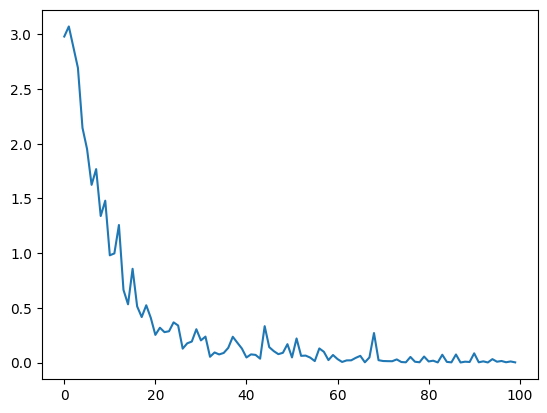

In [10]:
plt.plot(losses)
plt.show()

In [13]:
model.eval()
with torch.no_grad():
    correct = 0.
    for x,y in trainDataLoader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        correct += (pred.argmax(1) == y).type(torch.float32).sum()
    acc = correct/len(trainDataLoader.dataset)
    print(f'Acc is {acc}')
    print(f'Correct = {correct}')
    print(f'Total {len(trainDataLoader.dataset)}')

Acc is 0.9998232126235962
Correct = 11312.0
Total 11314


In [14]:
model.eval()
with torch.no_grad():
    correct = 0.
    for x,y in testDataLoader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        correct += (pred.argmax(1) == y).type(torch.float32).sum()
    acc = correct/len(testDataLoader.dataset)
    print(f'Acc is {acc}')
    print(f'Correct = {correct}')
    print(f'Total {len(testDataLoader.dataset)}')

Acc is 0.7918215394020081
Correct = 5964.0
Total 7532
